## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
# 載入 Callbacks
model_ckpt1 = ModelCheckpoint(filepath="./tmp1.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

model_ckpt2 = ModelCheckpoint(filepath="./tmp2.h5", 
                             monitor="val_loss", 
                             save_best_only=False)
name_tag = ['Model_w_cp', 'Model_w/t_cp']

results = {}
for name in name_tag:
    keras.backend.clear_session()
    print("Experiment with %s" % (name))
    if name == 'Model_w_cp':
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[model_ckpt1]
                 )
    else:
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[model_ckpt2]
                 )    
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-%s" % str(name)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

# Load back1
model1 = keras.models.load_model("./tmp1.h5")
loss_loadback1, acc_loadback1 = model.evaluate(x_test, y_test)
# Load back2
model2 = keras.models.load_model("./tmp2.h5")
loss_loadback2, acc_loadback2 = model.evaluate(x_test, y_test)

Experiment with Model_w_cp
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (No

50000/50000 [==============================] - 5s 95us/step - loss: 0.5562 - accuracy: 0.8364 - val_loss: 1.6247 - val_accuracy: 0.4999
Epoch 47/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.5396 - accuracy: 0.8428 - val_loss: 1.6381 - val_accuracy: 0.4961
Epoch 48/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.5234 - accuracy: 0.8496 - val_loss: 1.6574 - val_accuracy: 0.4894
Epoch 49/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.5075 - accuracy: 0.8565 - val_loss: 1.6697 - val_accuracy: 0.4962
Epoch 50/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.4935 - accuracy: 0.8602 - val_loss: 1.6786 - val_accuracy: 0.4906
Experiment with Model_w/t_cp
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
____________________________

50000/50000 [==============================] - 5s 98us/step - loss: 0.6493 - accuracy: 0.7998 - val_loss: 1.5575 - val_accuracy: 0.4956
Epoch 42/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.6285 - accuracy: 0.8077 - val_loss: 1.5664 - val_accuracy: 0.4956
Epoch 43/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.6130 - accuracy: 0.8149 - val_loss: 1.5888 - val_accuracy: 0.4910
Epoch 44/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.5963 - accuracy: 0.8214 - val_loss: 1.5932 - val_accuracy: 0.4929
Epoch 45/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.5779 - accuracy: 0.8286 - val_loss: 1.6105 - val_accuracy: 0.4969
Epoch 46/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.5612 - accuracy: 0.8361 - val_loss: 1.6161 - val_accuracy: 0.4918
Epoch 47/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.5417 - accuracy: 0.8450 - val_loss: 1.6354

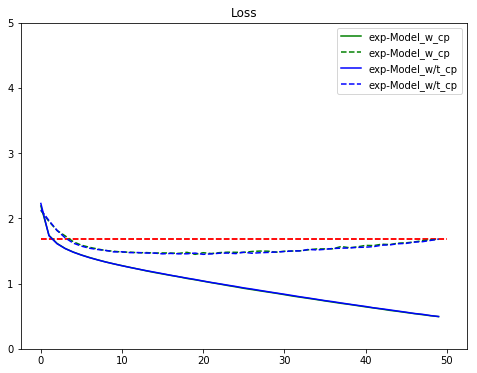

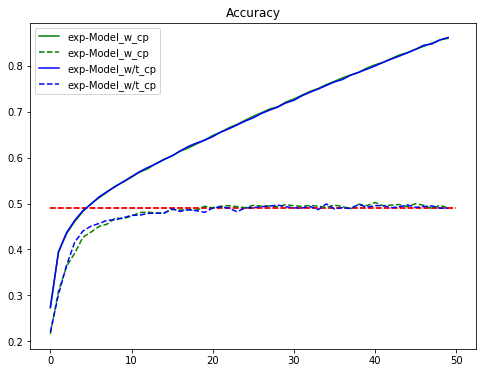

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["g", "b"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=loss_loadback1, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    #plt.hlines(y=loss_loadback2, xmin=0, xmax=len(train_loss), colors='y', linestyles='--')
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=acc_loadback1, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    #plt.hlines(y=acc_loadback2, xmin=0, xmax=len(train_loss), colors='y', linestyles='--')
plt.title("Accuracy")
plt.legend()
plt.show()

In [12]:
print(acc_loadback1, acc_loadback2)

0.49000000953674316 0.49000000953674316
